# Model Training 
    This notebook is a collection of training code used 

## Data
### Looking at the data

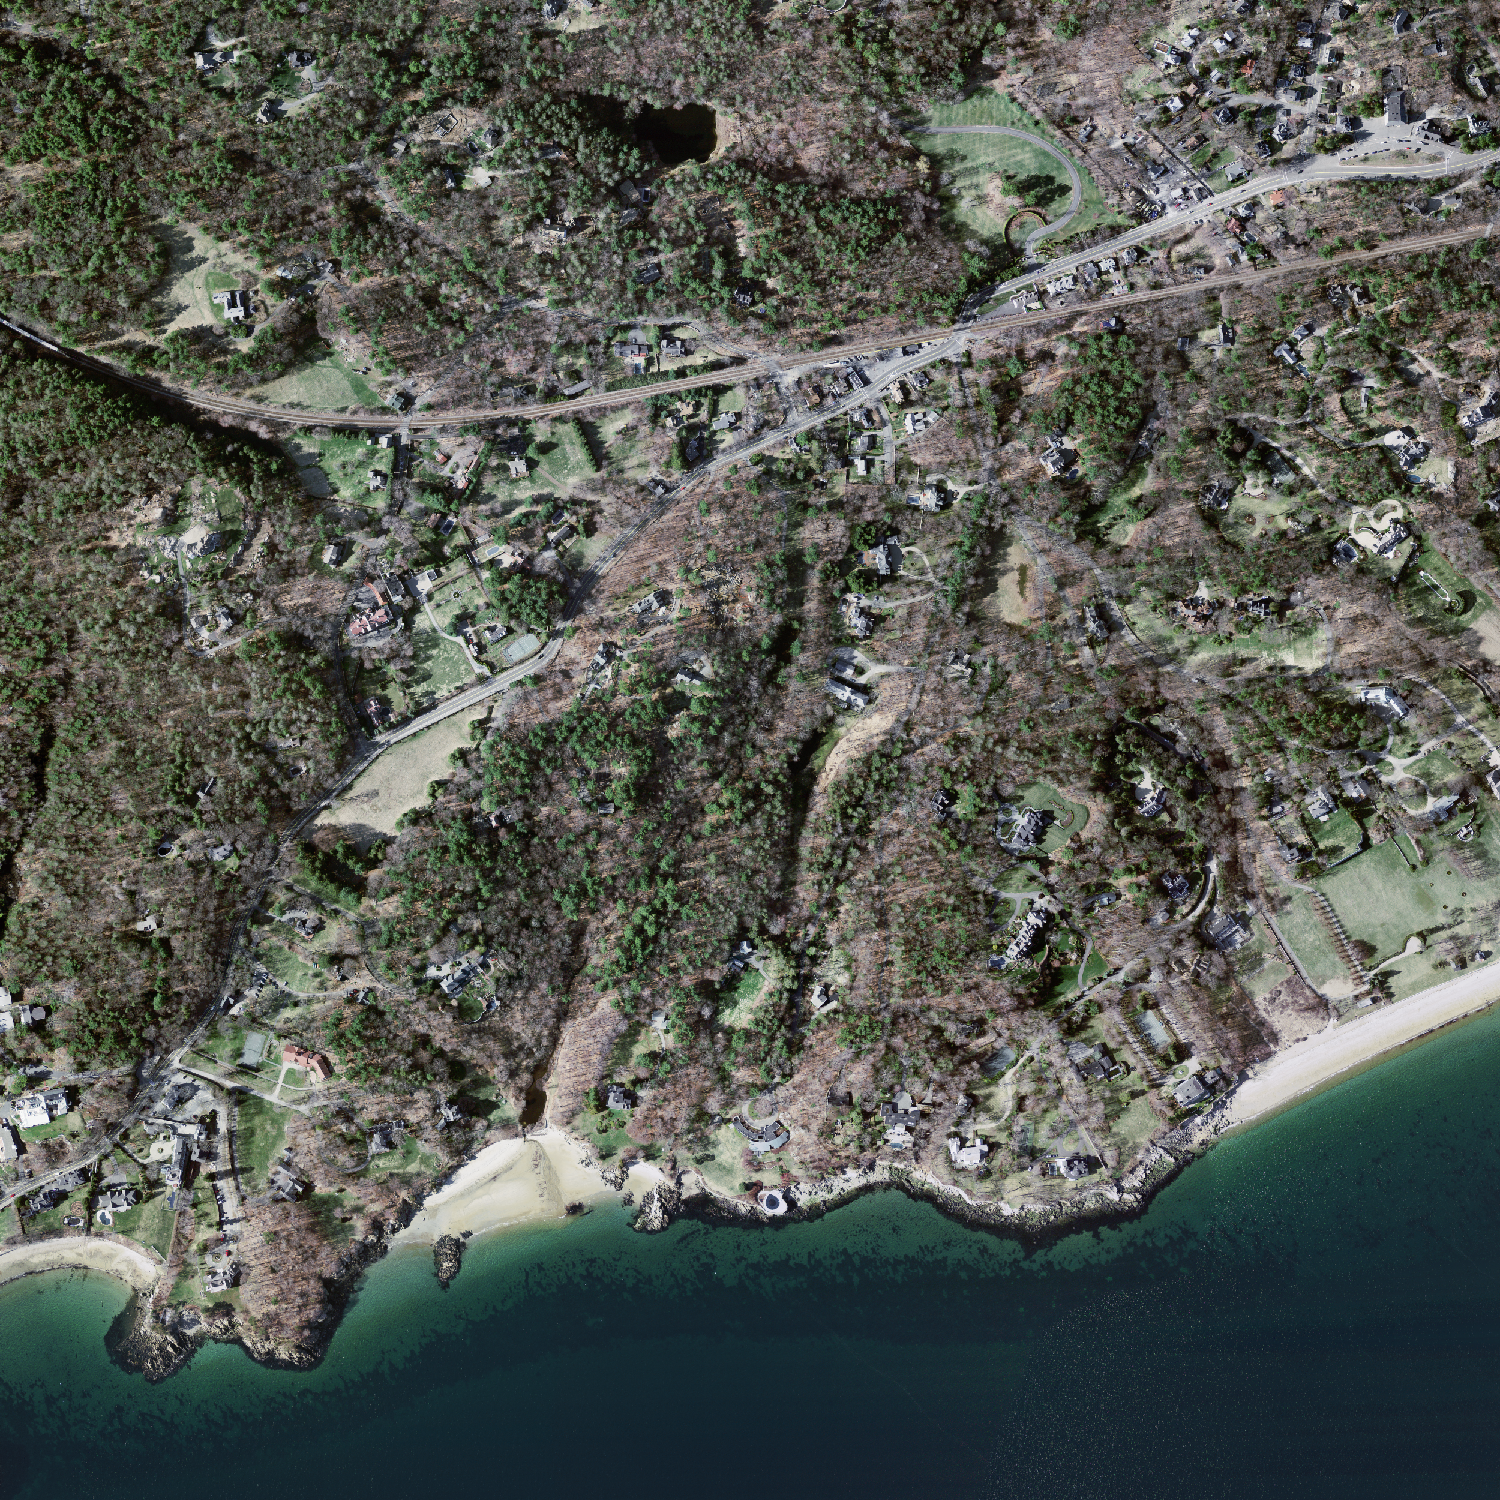

In [20]:
# View Satellite image
import matplotlib.pyplot as plt
from PIL import Image
import os

images = os.listdir('/home/ubuntu/segmentation/mass_roads/train/map')
image = Image.open('/home/ubuntu/segmentation/mass_roads/train/sat/'+images[1]+'f').convert("RGB")

image.show()

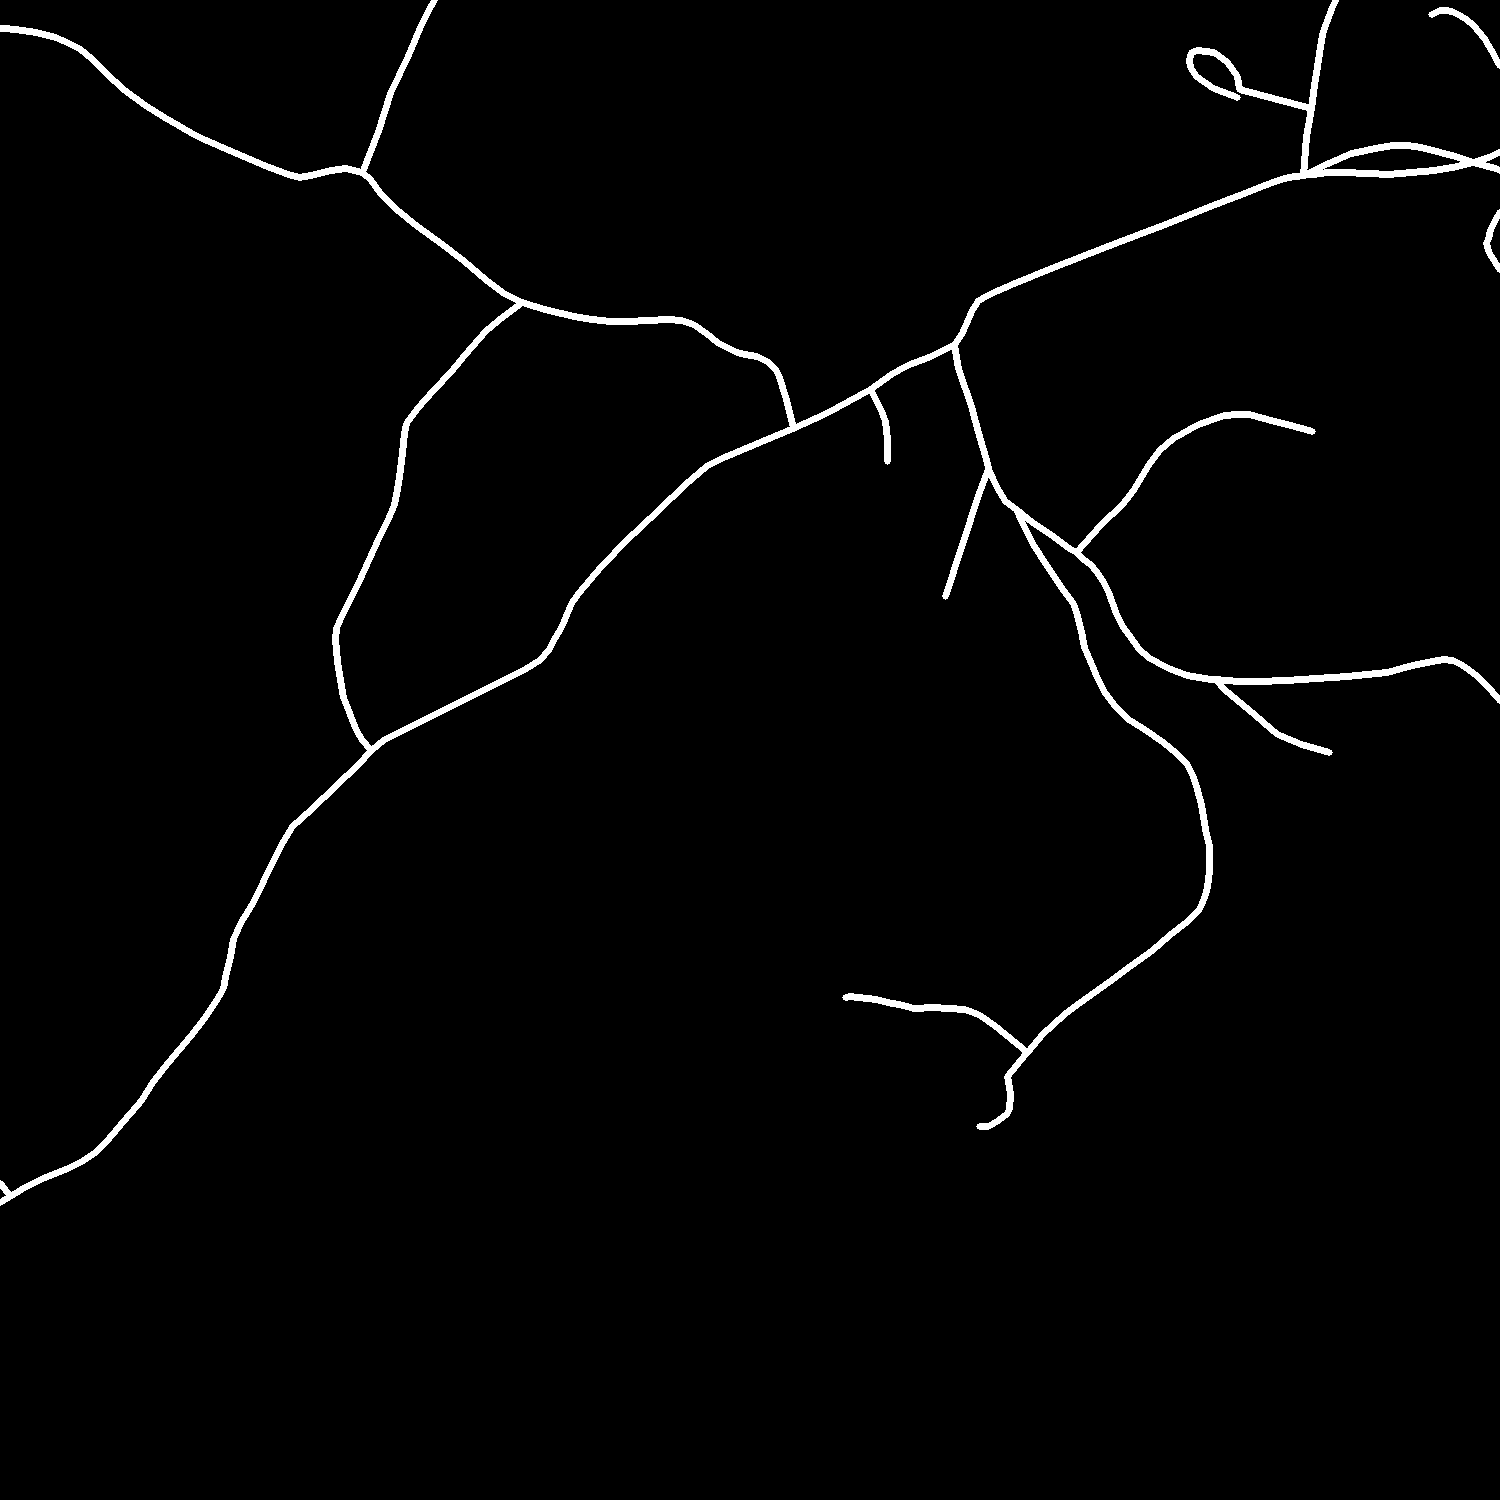

In [21]:
# View mask
mask = Image.open('/home/ubuntu/segmentation/mass_roads/train/map/'+images[1]).convert("RGB")
mask.show()

### Defining *Dataset* class

In [22]:
import torch
from torch.utils.data import Dataset
import numpy as np

class MapData(Dataset):
    def __init__(self, image_path, map_path, image_transform=None, mask_transform=None):
        self.image_path = image_path
        self.map_path = map_path
        self.maps = os.listdir(map_path)
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
    def __len__(self):
        return len(self.maps)
    
    def __getitem__(self, idx):
        '''
        Reuturn a image and corresponding map
        '''
        img_path = os.path.join(self.image_path, self.maps[idx]+'f')
        msk_path = os.path.join(self.map_path, self.maps[idx])
        # open as PIL image
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(msk_path).convert("L")
        # convert np array
        image_np = np.array(image)
        mask_np = np.array(mask,  dtype=np.float32)
        # apply transformations
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        
        return image, mask

### Defining transforms
    TODO: use more transforms

In [23]:
# define the transforms
import torchvision.transforms as tf
import torch.nn
image_transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((1500, 1500)),
    tf.Normalize((0,0,0),(1,1,1))
])
mask_transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((1500, 1500)),
    tf.Normalize((0), (1))
])

### Creating test and validation datasets

In [24]:
train_path = '/home/ubuntu/segmentation/mass_roads/train/sat/'
train_mask = '/home/ubuntu/segmentation/mass_roads/train/map/'
train_ds = MapData(image_path=train_path,
                   map_path=train_mask,
                   image_transform=image_transform,
                   mask_transform=mask_transform)

val_path = '/home/ubuntu/segmentation/mass_roads/valid/sat/'
val_masks = '/home/ubuntu/segmentation/mass_roads/valid/map/'
val_ds = MapData(image_path=val_path,
                   map_path=val_masks,
                   image_transform=tf.ToTensor(),
                   mask_transform=tf.ToTensor())

### Creating DataLoaders

In [25]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = 2
train_dl = DataLoader(dataset=train_ds,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      shuffle=True)
valid_dl = DataLoader(dataset=val_ds,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     shuffle=False)

In [26]:
# Testing the dataloader
loop = enumerate(train_dl)
batch, (image, mask) = next(loop)
print(f"image shape {image.shape}, mask shape: {mask.shape}")

image shape torch.Size([1, 3, 1500, 1500]), mask shape: torch.Size([1, 1, 1500, 1500])


## Model
    Using UNET_retain_imageDim from https://github.com/aryaman4152/model-implementations-pytorch/tree/main/UNET

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

"""
One convolution setion of the UNET
"""
class Section(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Section, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.process(x)
    
"""
UNET implementation
"""
class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNET, self).__init__()
        # Contraction
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down1 = Section(in_channels=in_channels, out_channels=64)
        self.down2 = Section(in_channels=64, out_channels=128)
        self.down3 = Section(in_channels=128, out_channels=256)
        self.down4 = Section(in_channels=256, out_channels=512)
        self.down5 = Section(in_channels=512, out_channels=1024)
        # Expansion
        self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up1 = Section(in_channels=1024, out_channels=512, kernel_size=3)
        self.up2 = Section(in_channels=512, out_channels=256, kernel_size=3)
        self.up3 = Section(in_channels=256, out_channels=128, kernel_size=3)
        self.up4 = Section(in_channels=128, out_channels=64, kernel_size=3)
        # Output 
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding='same')
        
    def forward(self, x):
        skip_connections = []
        #Contraction
        # down1
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down2
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 3
        x = self.down3(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 4
        x = self.down4(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 5
        x = self.down5(x)
        
        #Expansion
        # up1
        x = self.up_conv1(x)
        y = skip_connections[3]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up1(y_new)
        # up2
        x = self.up_conv2(x)
        y = skip_connections[2]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up2(y_new)
        # up3
        x = self.up_conv3(x)
        y = skip_connections[1]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up3(y_new)
        # up4 
        x = self.up_conv4(x)
        y = skip_connections[0]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up4(y_new)
        x = self.output(x)
        return x

In [28]:
'''
Testing the model to output shape
'''
model = UNET(in_channels=3, out_channels=1) # RGB -> SINGLE CHANNEL
x = torch.randn((1, 3, 160, 240))
pred = model(x)
pred.shape

torch.Size([1, 1, 160, 240])

## Training

### Defining the training loop
    NOTE: Omitted Validation loop in this notebook

In [29]:
def train_function(dataloader, model, optimizer, loss_fn, scaler):
    size = len(dataloader.dataset)
    for batch_idx, (image, mask) in enumerate(dataloader):
        image = image.to(device=DEVICE)
        mask = mask.float().to(device=DEVICE)
        
        #forward
        with torch.cuda.amp.autocast():
            prediction = model(image)
            loss = loss_fn(prediction, mask)
            
        #back
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if batch_idx%100 == 0:
            loss, current = loss.item(), batch_idx*len(image)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def validation_function(dataloader, model):
    pass

### Defining params

In [30]:
model = UNET(in_channels=3, out_channels=1) # RGB -> BW
model.to(device=DEVICE)
LEARNING_RATE = 1e-3
DEVICE = "cuda" 
BATCH_SIZE = 1 # Can use a higher batch size
EPOCHS = 7
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

## Training the model

In [33]:
def main():
    for j in range(EPOCHS):
        print(f" Epoch = {j} \n +++++++++++++++++++++++++++++++++++++")
        train_function(dataloader=train_dl,
                      model=model,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      scaler=scaler)

In [34]:
main()

 Epoch = 0 
 +++++++++++++++++++++++++++++++++++++
loss: 0.078594  [    0/ 1108]
loss: 0.073199  [  100/ 1108]
loss: 0.036928  [  200/ 1108]
loss: 0.200880  [  300/ 1108]
loss: 0.146923  [  400/ 1108]
loss: 0.129544  [  500/ 1108]
loss: 0.384137  [  600/ 1108]
loss: 0.124216  [  700/ 1108]
loss: 0.378267  [  800/ 1108]
loss: 0.063235  [  900/ 1108]
loss: 0.231919  [ 1000/ 1108]
loss: 0.116816  [ 1100/ 1108]
 Epoch = 1 
 +++++++++++++++++++++++++++++++++++++
loss: 0.157100  [    0/ 1108]
loss: 0.105680  [  100/ 1108]
loss: 0.063125  [  200/ 1108]
loss: 0.071569  [  300/ 1108]
loss: 0.104477  [  400/ 1108]
loss: 0.127959  [  500/ 1108]
loss: 0.138816  [  600/ 1108]
loss: 0.126157  [  700/ 1108]
loss: 0.100160  [  800/ 1108]
loss: 0.184881  [  900/ 1108]
loss: 0.131486  [ 1000/ 1108]
loss: 0.052043  [ 1100/ 1108]
 Epoch = 2 
 +++++++++++++++++++++++++++++++++++++
loss: 0.024500  [    0/ 1108]
loss: 0.214754  [  100/ 1108]
loss: 0.234878  [  200/ 1108]
loss: 0.486355  [  300/ 1108]
loss: 0

## Save the model

In [35]:
torch.save(model, 'model.pth')